In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
#from  utilities import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import h5py
import cv2

In [2]:
def initialisation (X):
    W=np.random.randn(X.shape[1],1)
    b=np.random.randn(1)
    return (W, b)

def model(X,W,b):
    Z=X.dot(W)+b
    A=1/(1+np.exp(-Z))
    return A

def logLoss(A,y):
    epsilon=1e-15
    return 1/len(y)*np.sum(-y*np.log(A+epsilon)-(1-y)*np.log(1-A+epsilon))

def gradients (A,X,y):
    dW=1/len(y)*np.dot(X.T,A-y)
    db=1/len(y)*sum(A-y)
    return (dW,db)

def update(dW,db, W, b, learning_rate):
    W=W-learning_rate*dW
    b=b-learning_rate*db
    return (W,b)

def prediction(X,W,b):
    A=model(X,W,b)
    #print(A)
    return A>=0.5

def artificialNeuron(x_train,y_train,x_test,y_test, learning_rate=0.01, n_iter=10000): 
    #initialisation
    W,b=initialisation(x_train) 
    train_cout=[]
    train_accuracy=[]
    test_cout=[]
    test_accuracy=[]
        
    cout=[] 
    accuracy=[]
    for i in tqdm(range(n_iter)): 
        # activation     
        A=model(x_train,W,b)
        if i%10==0:
            #train cout/accuracy
            train_cout.append(logLoss(A,y_train)) 
            #precision
            y_pred=prediction(x_train,W,b)
            train_accuracy.append(accuracy_score(y_train,y_pred))
            #test cout/accuracy
            A_test=model(x_test, W,b)
            test_cout.append(logLoss(A_test,y_test)) 
            #precision
            y_pred=prediction(x_test,W,b)
            test_accuracy.append(accuracy_score(y_test,y_pred))
                    
        #mise à jour
        dW,db=gradients(A,x_train,y_train)
        W,b= update(dW,db,W,b,learning_rate)
            
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_cout, label='train_cout')
    plt.plot(test_cout, label='test_cout')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(test_accuracy, label='test_accuracy')
    plt.legend()
    plt.show()
    return (W,b)

In [3]:
def images_to_hdf5_dataset(imageFormat, data_repo, h5file, img_width, img_height):
    nfiles = len(glob.glob(data_repo+"*.jpg"))
    print(f'count of image files nfiles={nfiles}')
    
    #on load les images de chats du training set pour les transformer en matrices
    with h5py.File(h5file,'w') as  h5f:
        x = h5f.create_dataset('X',shape=(nfiles, img_width, img_height), dtype=int)
        y = h5f.create_dataset('y',shape=(nfiles,), dtype=int)

        for cnt, ifile in tqdm(enumerate(glob.iglob(data_repo+"*."+imageFormat))):
            img = cv2.imread(ifile, cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize( img, (img_width, img_height) )

            x[cnt] = img_resize
            #le label est 1 si la photo contient un chat
            if 'cat' in ifile:
                y[cnt] = 1
            else:
                #le label est 0 si la photo contient un chien
                y[cnt] = 0


In [4]:
IMG_WIDTH = 64
IMG_HEIGHT = 64

repo_training_set = "data/train_set/"
repo_test_set = "data/test_set/"
dataset_train = "dataset/train_set.hdf5"
dataset_test = "dataset/test_set.hdf5"

#on convertit les images du train set en un fichier hdf5
images_to_hdf5_dataset("jpg", repo_training_set, dataset_train, IMG_WIDTH, IMG_HEIGHT)

#on fait la meme chose pour les images du test set
images_to_hdf5_dataset("jpg", repo_test_set, dataset_test, IMG_WIDTH, IMG_HEIGHT)

count of image files nfiles=8000


8000it [00:08, 910.75it/s] 


count of image files nfiles=2023


2023it [00:01, 1055.54it/s]


In [5]:
dataset_train = "dataset/train_set.hdf5"
dataset_test = "dataset/test_set.hdf5"

#on load le dataset d'entrainement
dataset = h5py.File(dataset_train, "r")

X_train = np.array(dataset["X"][:]) 
y_train = np.array(dataset["y"][:])

#on load le dataset de test
dataset = h5py.File(dataset_test, "r")

X_test = np.array(dataset["X"][:]) 
y_test = np.array(dataset["y"][:])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8000, 64, 64) (8000,)
(2023, 64, 64) (2023,)


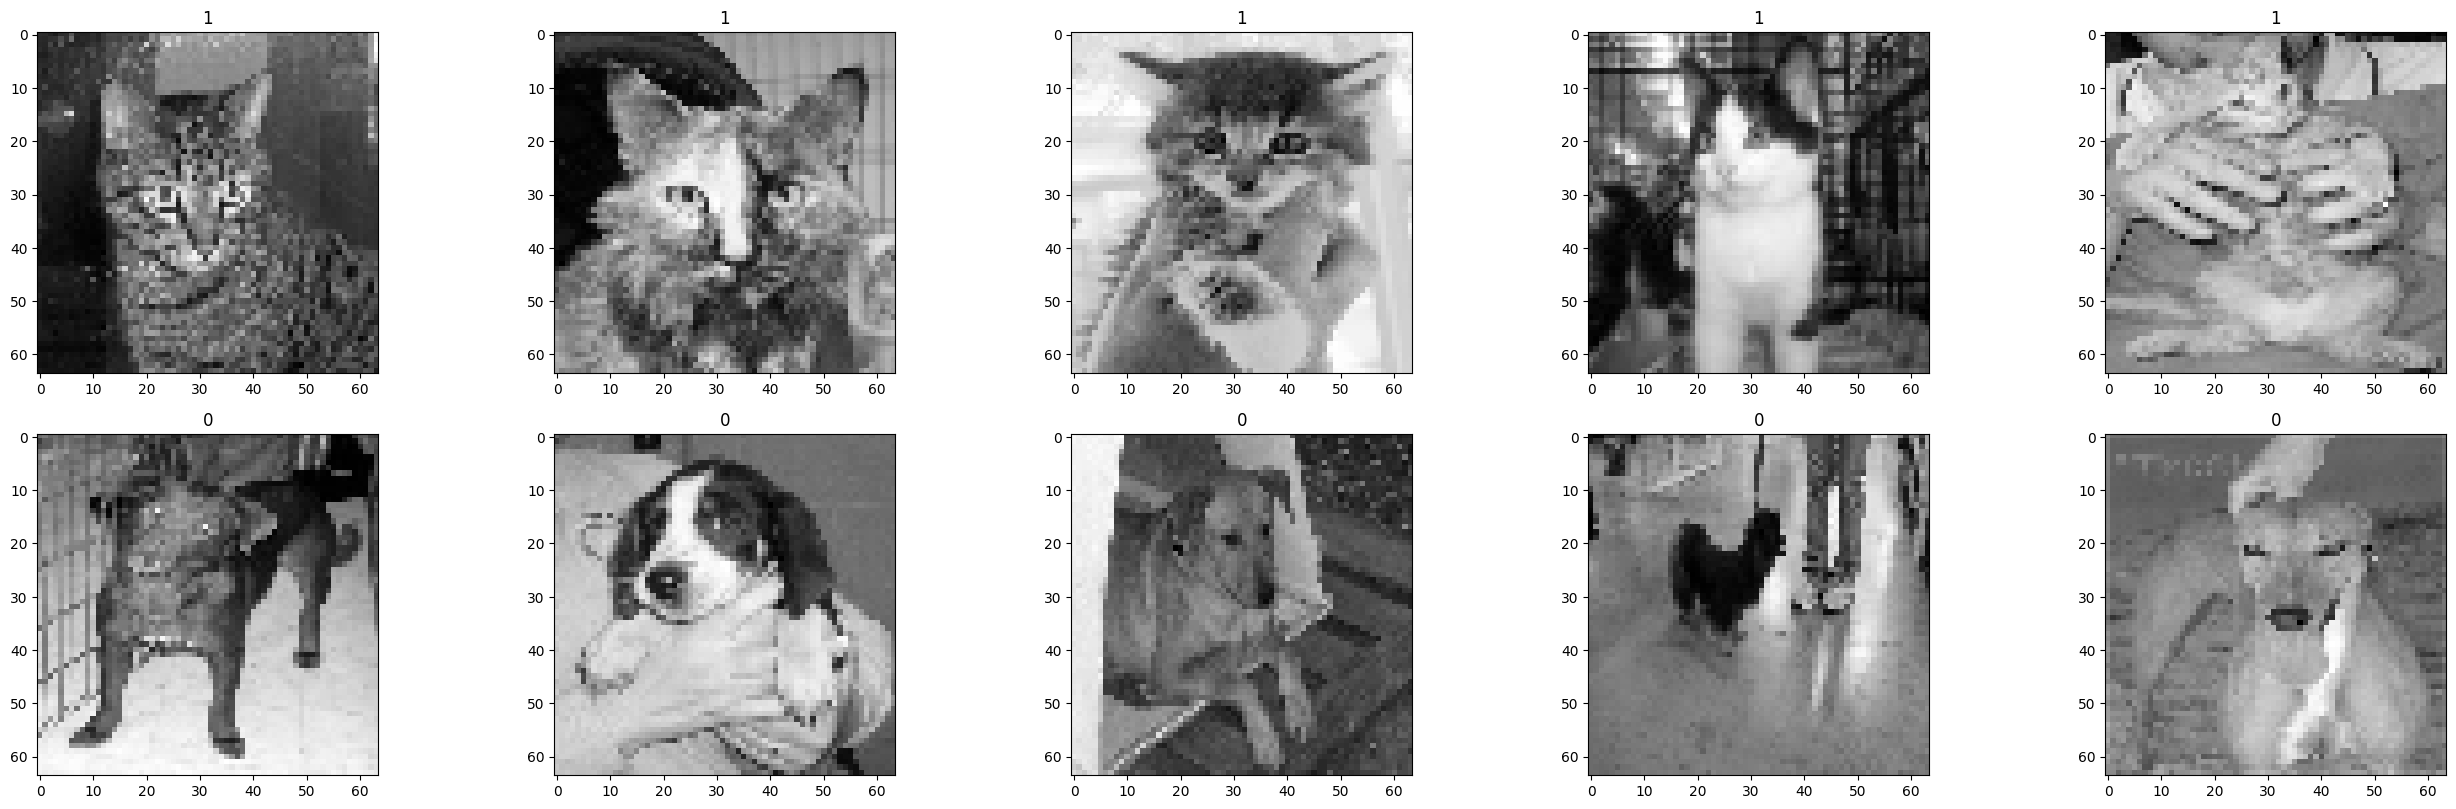

In [6]:
plt.figure(figsize=(26,16))
i = 0
j = 0
e = 1

for k in range(y_train.shape[0]):
    if i == 5 and j == 5:
        break
    
    if i < 5 and y_train[k] == 1:
        plt.subplot(4,5,e)
        plt.imshow(X_train[k],cmap='gray')
        plt.title (y_train[k])
        plt.tight_layout()
        i += 1
        e += 1
        
    elif j < 5 and y_train[k] == 0:
        plt.subplot(4,5,e)
        plt.imshow(X_train[k],cmap='gray')
        plt.title (y_train[k])
        plt.tight_layout()
        j += 1
        e += 1
        

In [7]:
#on change la taille de la matrice pour mettre les pixels de chaque image sur une même ligne
X_train_reshape = X_train.reshape(X_train.shape[0],-1)/X_train.max()
print(X_train.shape)

#on reshape la matrice y
y_train = y_train.reshape(y_train.shape[0], 1)

#on change la taille de la matrice
X_test_reshape = X_test.reshape(X_test.shape[0],-1)/X_test.max()
print(X_test.shape)

#on reshape la matrice y
y_test = y_test.reshape(y_test.shape[0], 1)

(8000, 64, 64)
(2023, 64, 64)


100%|██████████| 10000/10000 [03:19<00:00, 50.05it/s]


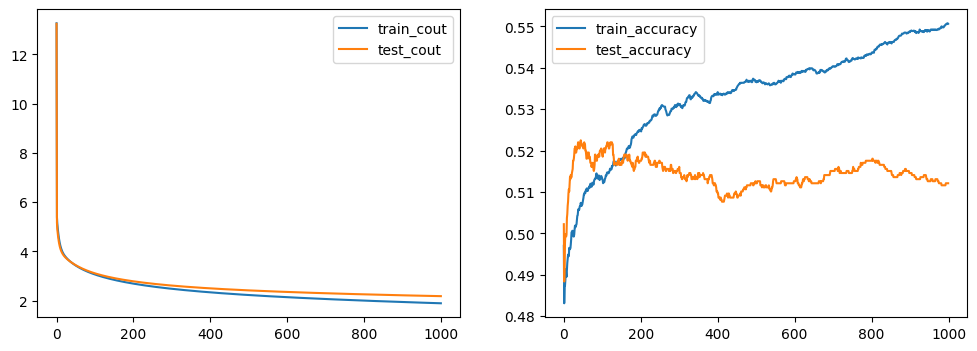

In [8]:
W,b=artificialNeuron(X_train_reshape,y_train, X_test_reshape, y_test, 0.01, 10000)

Matrice de confusion non normalisée
[[531 481]
 [506 505]]
              precision    recall  f1-score   support

       chats       0.51      0.52      0.52      1012
      chiens       0.51      0.50      0.51      1011

    accuracy                           0.51      2023
   macro avg       0.51      0.51      0.51      2023
weighted avg       0.51      0.51      0.51      2023



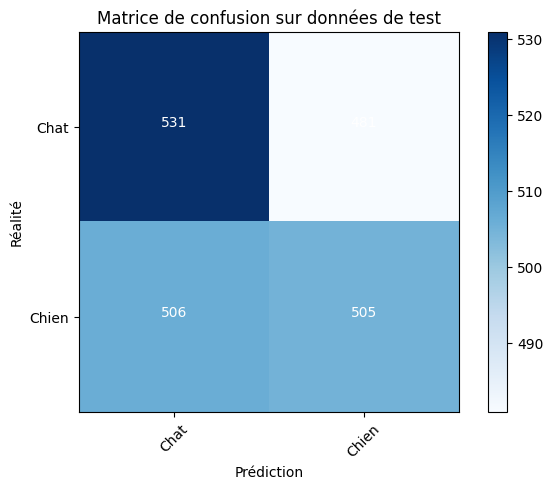

In [9]:
#Création de la matrice de confusion

from sklearn.metrics import confusion_matrix
import itertools
y_pred=prediction(X_test_reshape,W,b)
cm=confusion_matrix(y_test,y_pred)
cm_plot_labels=['Chat','Chien']
def plot_confusion_matrix(cm,classes,normalize=False,title='Matrice de confusion',cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    print("Matrice de confusion normalisée")
  else:
    print("Matrice de confusion non normalisée")

  print(cm)
  thresh=cm.max()/2.
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],
              horizontalalignment="center",
              color="white" if cm[i,j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('Réalité')
  plt.xlabel('Prédiction')
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Matrice de confusion sur données de test')

#Création du rapport de classification 

from sklearn.metrics import classification_report
target_names=['chats','chiens']
print(classification_report(y_test,y_pred,target_names=target_names))